# 230968011 - Abhinava Rao K S


## Week 4: Advanced CNN Architectures and Transfer Learning for Image Classification

## Overview
This assignment implements and compares CNN architectures (LeNet-5 and AlexNet) and evaluates transfer learning performance using pre-trained models on two datasets: Cats vs Dogs and Horse2Zebra.

## Objectives
1. Implement LeNet-5 and AlexNet CNN architectures from scratch
2. Train and evaluate these models on Cats_and_Dogs_Dataset and Horse2Zebra Dataset
3. Apply transfer learning using pre-trained models: VGG-16, GoogleNet, ResNet50, EfficientNetB0, MobileNetV2
4. Handle different directory structures and split datasets into train/test/val
5. Apply normalization and augmentation on both datasets
6. Compare performance across all models and datasets


## 1. Import Required Libraries and Setup

We import all necessary libraries for data processing, deep learning, and visualization.


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# Deep learning framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.regularizers import l2

# ALWAYS set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


Libraries imported successfully!
TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## 2. Dataset Preparation and Extraction

We extract and organize the datasets for further processing.


In [41]:
# Dataset paths - use local paths
cats_dogs_zip = "./cats_and_dogs_filtered.zip"
horse_zebra_zip = "./horses2zebras.zip"

# Extract Cats vs Dogs dataset
if os.path.exists(cats_dogs_zip):
    print(f"Extracting {cats_dogs_zip}...")
    with zipfile.ZipFile(cats_dogs_zip, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Cats and Dogs dataset extracted successfully.")
else:
    print(f"{cats_dogs_zip} not found, checking if already extracted.")

# Extract Horse2Zebra dataset
if os.path.exists(horse_zebra_zip):
    print(f"Extracting {horse_zebra_zip}...")
    with zipfile.ZipFile(horse_zebra_zip, 'r') as zip_ref:
        zip_ref.extractall("horses2zebras")
    print("Horse2Zebra dataset extracted successfully.")
else:
    print(f"{horse_zebra_zip} not found, checking if already extracted.")

# Verify Cats vs Dogs dataset structure
cats_dogs_path = "/kaggle/input/week4img2/cats_and_dogs_filtered/cats_and_dogs_filtered"
if os.path.exists(cats_dogs_path):
    print(f"Cats and Dogs dataset found at: {cats_dogs_path}")
    train_cats = len(os.listdir(f"{cats_dogs_path}/train/cats"))
    train_dogs = len(os.listdir(f"{cats_dogs_path}/train/dogs"))
    val_cats = len(os.listdir(f"{cats_dogs_path}/validation/cats"))
    val_dogs = len(os.listdir(f"{cats_dogs_path}/validation/dogs"))
    print(f"Dataset structure:")
    print(f"  Training: {train_cats} cats, {train_dogs} dogs")
    print(f"  Validation: {val_cats} cats, {val_dogs} dogs")
    print(f"  Total: {train_cats + train_dogs + val_cats + val_dogs} images")

# Verify Horse2Zebra dataset structure and reorganize for classification
src_dir = Path("/kaggle/input/week4img2/horses2zebras")
dst_dir = Path("dataset_condensed")
mapping = {
    "trainA": ("train", "horse"),
    "trainB": ("train", "zebra"),
    "testA":  ("test",  "horse"),
    "testB":  ("test",  "zebra"),
}

# Create organized directory structure for Horse2Zebra
if src_dir.exists():
    print("Horse2Zebra dataset found. Organizing for classification...")
    dst_dir.mkdir(parents=True, exist_ok=True)
    rows = []

    for src_name, (split, cls) in mapping.items():
        src_folder = src_dir / src_name
        out_dir = dst_dir / split / cls
        out_dir.mkdir(parents=True, exist_ok=True)
        
        if not src_folder.exists():
            continue
            
        for i, img_path in enumerate(src_folder.glob("*.jpg")):
            if not img_path.is_file():
                continue
            out_path = out_dir / f"{cls}_{i:06d}{img_path.suffix.lower()}"
            # Copy file if it doesn't already exist
            if not out_path.exists():
                out_path.parent.mkdir(parents=True, exist_ok=True)
                import shutil
                shutil.copy2(img_path, out_path)
            rows.append([str(out_path), 0 if cls=="horse" else 1])

    print("Horse2Zebra dataset organization complete.")
    # Count organized images
    horse_train = len(list((dst_dir / "train" / "horse").glob("*.jpg")))
    zebra_train = len(list((dst_dir / "train" / "zebra").glob("*.jpg")))
    horse_test = len(list((dst_dir / "test" / "horse").glob("*.jpg")))
    zebra_test = len(list((dst_dir / "test" / "zebra").glob("*.jpg")))
    
    print(f"Organized Horse2Zebra dataset:")
    print(f"  Training: {horse_train} horses, {zebra_train} zebras")
    print(f"  Test: {horse_test} horses, {zebra_test} zebras")
    print(f"  Total: {horse_train + zebra_train + horse_test + zebra_test} images")
else:
    print("Horse2Zebra dataset not found.")


./cats_and_dogs_filtered.zip not found, checking if already extracted.
./horses2zebras.zip not found, checking if already extracted.
Cats and Dogs dataset found at: /kaggle/input/week4img2/cats_and_dogs_filtered/cats_and_dogs_filtered
Dataset structure:
  Training: 1000 cats, 1000 dogs
  Validation: 500 cats, 500 dogs
  Total: 3000 images
Horse2Zebra dataset found. Organizing for classification...
Horse2Zebra dataset organization complete.
Organized Horse2Zebra dataset:
  Training: 1067 horses, 1334 zebras
  Test: 120 horses, 140 zebras
  Total: 2661 images


## 3. Data Loading and Augmentation

We load the datasets with proper normalization and augmentation techniques to enhance model performance.


In [42]:
# Common parameters for both datasets
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# --- Horse2Zebra Dataset Loading and Preprocessing ---
CLASSES_HORSEZEBRA = ["horse", "zebra"]

if os.path.exists(dst_dir / "train"):
    # Data augmentation for Horse2Zebra
    augmentation_h2z = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1)
    ])

    # Load train/val splits from organized directory
    h2z_train = tf.keras.utils.image_dataset_from_directory(
        f"{dst_dir}/train",
        labels="inferred",
        label_mode="int",
        class_names=CLASSES_HORSEZEBRA,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode="rgb",
    )

    h2z_val = tf.keras.utils.image_dataset_from_directory(
        f"{dst_dir}/train",
        labels="inferred",
        label_mode="int",
        class_names=CLASSES_HORSEZEBRA,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode="rgb",
    )

    h2z_test = tf.keras.utils.image_dataset_from_directory(
        f"{dst_dir}/test",
        labels="inferred",
        label_mode="int",
        class_names=CLASSES_HORSEZEBRA,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        shuffle=False
    )

    # Apply augmentation and normalization
    h2z_train = (h2z_train
    .map(lambda x,y: (augmentation_h2z(x, training=True), y), num_parallel_calls=AUTOTUNE)
    .map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
    .cache().prefetch(AUTOTUNE))

    h2z_val = (h2z_val
    .map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
    .cache().prefetch(AUTOTUNE))

    h2z_test = (h2z_test
    .map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
    .cache().prefetch(AUTOTUNE))
    
    print("Horse2Zebra dataset loaded successfully with augmentation and normalization.")

# --- Cats vs Dogs Dataset Loading and Preprocessing ---
CLASSES_CATDOG = ['cats', 'dogs']

if os.path.exists(cats_dogs_path):
    # Data augmentation for Cats vs Dogs
    augmentation_cd = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1)
    ])

    # Training split (80%)
    cats_dogs_train = image_dataset_from_directory(
        f"{cats_dogs_path}/train",
        labels="inferred",
        class_names=CLASSES_CATDOG,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode="rgb"
    )

    # Validation split (10%)
    cats_dogs_val = image_dataset_from_directory(
        f"{cats_dogs_path}/train",
        labels="inferred",
        class_names=CLASSES_CATDOG,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode="rgb"
    )

    # Test split (10%) - Use validation data from original dataset
    cats_dogs_test = image_dataset_from_directory(
        f"{cats_dogs_path}/validation",
        labels="inferred",
        class_names=CLASSES_CATDOG,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode="rgb"
    )

    # Apply augmentation and normalization
    cats_dogs_train = (cats_dogs_train
    .map(lambda x,y: (augmentation_cd(x, training=True), y), num_parallel_calls=AUTOTUNE)
    .map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
    .cache().prefetch(AUTOTUNE))

    cats_dogs_val = (cats_dogs_val
    .map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
    .cache().prefetch(AUTOTUNE))

    cats_dogs_test = (cats_dogs_test
    .map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
    .cache().prefetch(AUTOTUNE))
    
    print("Cats vs Dogs dataset loaded successfully with augmentation and normalization.")


Found 2401 files belonging to 2 classes.
Using 1921 files for training.
Found 2401 files belonging to 2 classes.
Using 480 files for validation.
Found 260 files belonging to 2 classes.
Horse2Zebra dataset loaded successfully with augmentation and normalization.
Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.
Found 1000 files belonging to 2 classes.
Cats vs Dogs dataset loaded successfully with augmentation and normalization.


## 4. Visualizing Augmented Training Data

We visualize a few samples of our augmented training data to ensure our augmentation pipeline is working correctly.


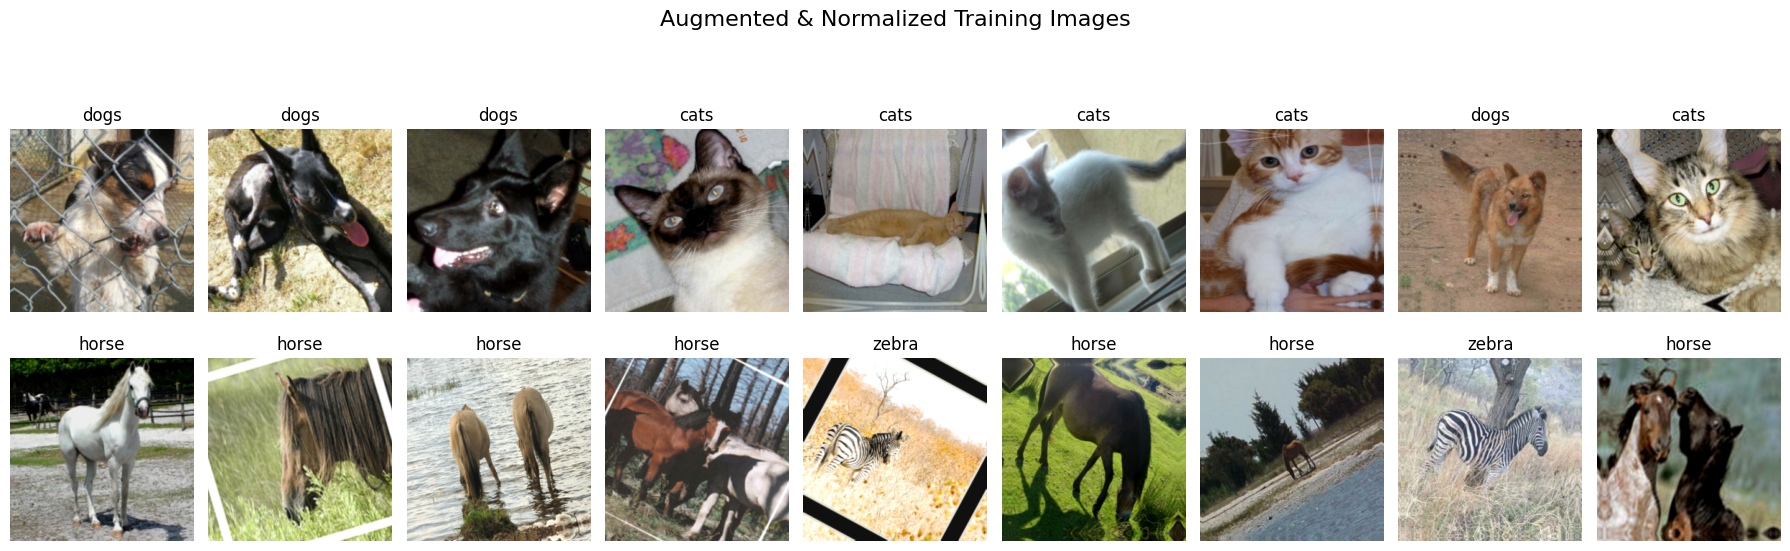

In [43]:
# Visualize data augmentation for both datasets
plt.figure(figsize=(18, 6))

# Cats & Dogs (row 1)
if 'cats_dogs_train' in locals():
    for images, labels in cats_dogs_train.take(1):
        for i in range(9):
            ax = plt.subplot(2, 9, i + 1)
            img = tf.clip_by_value(images[i], 0.0, 1.0)
            plt.imshow(img)
            plt.title(CLASSES_CATDOG[labels[i].numpy()])
            plt.axis("off")

# Horse & Zebra (row 2)
if 'h2z_train' in locals():
    for images, labels in h2z_train.take(1):
        for i in range(9):
            ax = plt.subplot(2, 9, i + 10)  # row 2 starts at 10
            img = tf.clip_by_value(images[i], 0.0, 1.0)
            plt.imshow(img)
            plt.title(CLASSES_HORSEZEBRA[labels[i].numpy()])
            plt.axis("off")

plt.suptitle("Augmented & Normalized Training Images", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

## 5. LeNet-5 Architecture Implementation

We implement the classic CNN architecture from Yann LeCun (1998).


In [44]:
# LeNet-5 Architecture Implementation
lenet5_model = Sequential([
    # Input layer
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    
    # First convolutional block
    layers.Conv2D(6, (5, 5), activation='tanh', padding='same'),
    BatchNormalization(),
    layers.AveragePooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(16, (5, 5), activation='tanh', padding='valid'),
    BatchNormalization(),
    layers.AveragePooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(120, (5, 5), activation='tanh', padding='valid'),
    BatchNormalization(),
    
    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dense(84, activation='tanh', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    layers.Dense(2, activation='softmax')  # 2 classes for binary classification
], name='LeNet5')

lenet5_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("LeNet-5 Model Summary:")
lenet5_model.summary()


LeNet-5 Model Summary:


Model: "LeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_123 (Conv2D)             │ (None, 256, 256, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 256, 256, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_25            │ (None, 128, 128, 6)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 124, 124, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 124, 124, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_26            │ (None, 62, 62, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_125 (Conv2D)             │ (None, 58, 58, 120)    │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 58, 58, 120)    │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 403680)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 84)             │    33,909,204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 84)             │           336 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,961,270 (129.55 MB)

 Trainable params: 33,960,818 (129.55 MB)

 Non-trainable params: 452 (1.77 KB)

## 6. AlexNet Architecture Implementation

We implement the influential deep CNN architecture from Krizhevsky et al. (2012).


In [45]:
# AlexNet Architecture Implementation
alexnet_model = Sequential([
    # Input layer
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    
    # First convolutional block
    layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D((3, 3), strides=(2, 2)),
    
    # Second convolutional block
    layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D((3, 3), strides=(2, 2)),
    
    # Third convolutional block
    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    # Fourth convolutional block
    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    # Fifth convolutional block
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D((3, 3), strides=(2, 2)),
    
    # Fully connected layers
    layers.Flatten(),
    layers.Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(4096, activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(2, activation='softmax')  # 2 classes for binary classification
], name='AlexNet')

alexnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("AlexNet Model Summary:")
alexnet_model.summary()


AlexNet Model Summary:


Model: "AlexNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_126 (Conv2D)             │ (None, 64, 64, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 64, 64, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 31, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 31, 31, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 31, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 15, 15, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 15, 15, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 15, 15, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ (None, 15, 15, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 15, 15, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4096)           │    51,384,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 71,959,298 (274.50 MB)

 Trainable params: 71,940,162 (274.43 MB)

 Non-trainable params: 19,136 (74.75 KB)

## 7. Transfer Learning Models

We implement transfer learning using five pre-trained ImageNet models: VGG-16, GoogleNet (InceptionV3), ResNet50, EfficientNetB0, and MobileNetV2.


In [46]:
# Transfer Learning Models Implementation
transfer_models = {}

# VGG16 Transfer Learning Model
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model_vgg16.trainable = False  # Freeze the base model layers

vgg16_model = Sequential([
    base_model_vgg16,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
], name='TransferLearning_VGG16')

vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
transfer_models['VGG16'] = vgg16_model

# InceptionV3 (GoogleNet) Transfer Learning Model
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model_inception.trainable = False  # Freeze the base model layers

inception_model = Sequential([
    base_model_inception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
], name='TransferLearning_InceptionV3')

inception_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
transfer_models['InceptionV3'] = inception_model

# ResNet50 Transfer Learning Model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model_resnet.trainable = False  # Freeze the base model layers

resnet_model = Sequential([
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
], name='TransferLearning_ResNet50')

resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
transfer_models['ResNet50'] = resnet_model

# EfficientNetB0 Transfer Learning Model
base_model_efficient = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model_efficient.trainable = False  # Freeze the base model layers

efficient_model = Sequential([
    base_model_efficient,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
], name='TransferLearning_EfficientNetB0')

efficient_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
transfer_models['EfficientNetB0'] = efficient_model

# MobileNetV2 Transfer Learning Model
base_model_mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model_mobile.trainable = False  # Freeze the base model layers

mobile_model = Sequential([
    base_model_mobile,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
], name='TransferLearning_MobileNetV2')

mobile_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
transfer_models['MobileNetV2'] = mobile_model

print(f"Created {len(transfer_models)} transfer learning models successfully.")


Created 5 transfer learning models successfully.


## 8. Training Configuration and Callbacks

We set up training parameters and callbacks for optimal model training.


In [47]:
# Training parameters and callbacks setup
EPOCHS = 15  # Adjust as needed
PATIENCE = 5

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

print(f"Training configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Patience: {PATIENCE}")
print(f"  Callbacks: Early Stopping, Learning Rate Reduction")


Training configuration:
  Epochs: 15
  Patience: 5
  Callbacks: Early Stopping, Learning Rate Reduction


## 9. Model Training and Evaluation: Cats vs Dogs Dataset

We train and evaluate our models on the Cats vs Dogs dataset.


In [48]:
# Dictionary to store all results
cats_dogs_results = {}

# Train and evaluate on Cats vs Dogs dataset
if 'cats_dogs_train' in locals():
    print("Starting model training on Cats vs Dogs dataset")
    
    # Train LeNet-5
    print("\nTraining LeNet-5 on Cats vs Dogs dataset...")
    start_time = time.time()
    history_lenet5 = lenet5_model.fit(
        cats_dogs_train,
        validation_data=cats_dogs_val,
        epochs=EPOCHS,
        callbacks=callbacks
    )
    train_time_lenet5 = time.time() - start_time
    
    # Evaluate LeNet-5
    test_loss_lenet5, test_acc_lenet5 = lenet5_model.evaluate(cats_dogs_test)
    cats_dogs_results['LeNet-5'] = {
        'model': lenet5_model,
        'history': history_lenet5,
        'test_accuracy': test_acc_lenet5,
        'test_loss': test_loss_lenet5,
        'training_time': train_time_lenet5
    }
    
    # Train AlexNet
    print("\nTraining AlexNet on Cats vs Dogs dataset...")
    start_time = time.time()
    history_alexnet = alexnet_model.fit(
        cats_dogs_train,
        validation_data=cats_dogs_val,
        epochs=EPOCHS,
        callbacks=callbacks
    )
    train_time_alexnet = time.time() - start_time
    
    # Evaluate AlexNet
    test_loss_alexnet, test_acc_alexnet = alexnet_model.evaluate(cats_dogs_test)
    cats_dogs_results['AlexNet'] = {
        'model': alexnet_model,
        'history': history_alexnet,
        'test_accuracy': test_acc_alexnet,
        'test_loss': test_loss_alexnet,
        'training_time': train_time_alexnet
    }
    
    # Train and evaluate transfer learning models
    for model_name, model in transfer_models.items():
        print(f"\nTraining {model_name} on Cats vs Dogs dataset...")
        start_time = time.time()
        history = model.fit(
            cats_dogs_train,
            validation_data=cats_dogs_val,
            epochs=EPOCHS,
            callbacks=callbacks
        )
        train_time = time.time() - start_time
        
        # Evaluate model
        test_loss, test_acc = model.evaluate(cats_dogs_test)
        cats_dogs_results[model_name] = {
            'model': model,
            'history': history,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'training_time': train_time
        }
    
    # Print summary of results
    print("\nCats vs Dogs Dataset - Results Summary:")
    for model_name, result in cats_dogs_results.items():
        print(f"  {model_name}: Test Accuracy = {result['test_accuracy']:.4f}, Training Time = {result['training_time']:.2f}s")


Starting model training on Cats vs Dogs dataset

Training LeNet-5 on Cats vs Dogs dataset...
Epoch 1/15


I0000 00:00:1755856123.692359     109 service.cc:148] XLA service 0x7d5eb8002180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755856123.693322     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755856123.693364     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755856124.588921     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5851 - loss: 2.3261

I0000 00:00:1755856130.569499     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - accuracy: 0.5166 - loss: 2.4363 - val_accuracy: 0.5750 - val_loss: 2.1011 - learning_rate: 0.0010
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5309 - loss: 2.1529 - val_accuracy: 0.5175 - val_loss: 2.0345 - learning_rate: 0.0010
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4850 - loss: 2.0840 - val_accuracy: 0.5675 - val_loss: 1.9870 - learning_rate: 0.0010
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5229 - loss: 2.0067 - val_accuracy: 0.5025 - val_loss: 1.9307 - learning_rate: 0.0010
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5146 - loss: 1.9342 - val_accuracy: 0.5325 - val_loss: 1.9405 - learning_rate: 0.0010
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5345 - loss: 1.9283 - val_accuracy: 0.5275 - val_loss: 1.8651 - learning_rate: 0.0010
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
32/32 ━━━━━━━━━━━━━━

2025-08-22 09:51:05.942500: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,64,64]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-22 09:51:06.038867: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.096480568s
Trying algorithm eng12{k11=0} for conv (f32[32,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,64,64]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward

50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 582ms/step - accuracy: 0.5504 - loss: 0.8188 - val_accuracy: 0.4675 - val_loss: 0.6832 - learning_rate: 1.0000e-04
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 319ms/step - accuracy: 0.7695 - loss: 0.5022 - val_accuracy: 0.5400 - val_loss: 0.6285 - learning_rate: 1.0000e-04
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - accuracy: 0.8116 - loss: 0.4065 - val_accuracy: 0.6425 - val_loss: 0.5664 - learning_rate: 1.0000e-04
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 317ms/step - accuracy: 0.8462 - loss: 0.3735 - val_accuracy: 0.8075 - val_loss: 0.4870 - learning_rate: 1.0000e-04
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 319ms/step - accuracy: 0.8612 - loss: 0.3412 - val_accuracy: 0.8475 - val_loss: 0.4181 - learning_rate: 1.0000e-04
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 319ms/step - accuracy: 0.8619 - loss: 0.3180 - val_accuracy: 0.8925 - val_loss: 0.3506 - learning_rate: 1.0000e-04
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - accuracy: 0.86

E0000 00:00:1755856735.940838     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755856736.126080     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5247 - loss: 0.7535

E0000 00:00:1755856754.442527     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755856754.602813     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 302ms/step - accuracy: 0.5240 - loss: 0.7534 - val_accuracy: 0.5450 - val_loss: 0.6900 - learning_rate: 1.0000e-04
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4787 - loss: 0.7547 - val_accuracy: 0.4550 - val_loss: 0.7187 - learning_rate: 1.0000e-04
Epoch 3/15
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5169 - loss: 0.7224
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5167 - loss: 0.7227 - val_accuracy: 0.5175 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.4954 - loss: 0.7272 - val_accuracy: 0.5450 - val_loss: 0.7084 - learning_rate: 5.0000e-05
Epoch 5/15
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4942 - loss: 0.7366
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.4944 - loss: 0.7365 - va

E0000 00:00:1755856774.562823     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755856774.708531     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.4860 - loss: 0.7056

Training MobileNetV2 on Cats vs Dogs dataset...
Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - accuracy: 0.7858 - loss: 0.4623 - val_accuracy: 0.9500 - val_loss: 0.1725 - learning_rate: 1.0000e-04
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9650 - loss: 0.1046 - val_accuracy: 0.9775 - val_loss: 0.0960 - learning_rate: 1.0000e-04
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9749 - loss: 0.0649 - val_accuracy: 0.9925 - val_loss: 0.0586 - learning_rate: 1.0000e-04
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9874 - loss: 0.0423 - val_accuracy: 0.9950 - val_loss: 0.0480 - learning_rate: 1.0000e-04
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9928 - loss: 0.0308 - val_accuracy: 0.9950 - val_loss: 0.0448 - learning_rate: 1.0000e-04
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9971 - loss: 0.0194 - val_accuracy

## 10. Model Training and Evaluation: Horse vs Zebra Dataset

We train and evaluate our models on the Horse vs Zebra dataset.


In [49]:
# Dictionary to store all results
horse_zebra_results = {}

# Train and evaluate on Horse vs Zebra dataset
if 'h2z_train' in locals():
    print("Starting model training on Horse vs Zebra dataset")
    
    # Train LeNet-5
    print("\nTraining LeNet-5 on Horse vs Zebra dataset...")
    start_time = time.time()
    history_lenet5 = lenet5_model.fit(
        h2z_train,
        validation_data=h2z_val,
        epochs=EPOCHS,
        callbacks=callbacks
    )
    train_time_lenet5 = time.time() - start_time
    
    # Evaluate LeNet-5
    test_loss_lenet5, test_acc_lenet5 = lenet5_model.evaluate(h2z_test)
    horse_zebra_results['LeNet-5'] = {
        'model': lenet5_model,
        'history': history_lenet5,
        'test_accuracy': test_acc_lenet5,
        'test_loss': test_loss_lenet5,
        'training_time': train_time_lenet5
    }
    
    # Train AlexNet
    print("\nTraining AlexNet on Horse vs Zebra dataset...")
    start_time = time.time()
    history_alexnet = alexnet_model.fit(
        h2z_train,
        validation_data=h2z_val,
        epochs=EPOCHS,
        callbacks=callbacks
    )
    train_time_alexnet = time.time() - start_time
    
    # Evaluate AlexNet
    test_loss_alexnet, test_acc_alexnet = alexnet_model.evaluate(h2z_test)
    horse_zebra_results['AlexNet'] = {
        'model': alexnet_model,
        'history': history_alexnet,
        'test_accuracy': test_acc_alexnet,
        'test_loss': test_loss_alexnet,
        'training_time': train_time_alexnet
    }
    
    # Train and evaluate transfer learning models
    for model_name, model in transfer_models.items():
        print(f"\nTraining {model_name} on Horse vs Zebra dataset...")
        start_time = time.time()
        history = model.fit(
            h2z_train,
            validation_data=h2z_val,
            epochs=EPOCHS,
            callbacks=callbacks
        )
        train_time = time.time() - start_time
        
        # Evaluate model
        test_loss, test_acc = model.evaluate(h2z_test)
        horse_zebra_results[model_name] = {
            'model': model,
            'history': history,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'training_time': train_time
        }
    
    # Print summary of results
    print("\nHorse vs Zebra Dataset - Results Summary:")
    for model_name, result in horse_zebra_results.items():
        print(f"  {model_name}: Test Accuracy = {result['test_accuracy']:.4f}, Training Time = {result['training_time']:.2f}s")


Starting model training on Horse vs Zebra dataset

Training LeNet-5 on Horse vs Zebra dataset...
Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.5334 - loss: 2.1541 - val_accuracy: 0.6042 - val_loss: 2.0576 - learning_rate: 0.0010
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6249 - loss: 2.0208 - val_accuracy: 0.6083 - val_loss: 1.9541 - learning_rate: 0.0010
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6021 - loss: 1.9347 - val_accuracy: 0.6146 - val_loss: 1.8620 - learning_rate: 0.0010
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6129 - loss: 1.8861 - val_accuracy: 0.5917 - val_loss: 1.7585 - learning_rate: 0.0010
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6221 - loss: 1.7433 - val_accuracy: 0.5500 - val_loss: 1.7323 - learning_rate: 0.0010
Epoch 6/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6125 - loss: 1.6735 - val_accuracy: 0.5813 - val_loss: 1.6561 - learning_rate: 0.

E0000 00:00:1755857387.506635     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755857387.655137     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755857387.787720     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.5290 - loss: 0.7243 - val_accuracy: 0.5792 - val_loss: 0.6782 - learning_rate: 2.5000e-05
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6002 - loss: 0.6633 - val_accuracy: 0.4750 - val_loss: 0.6897 - learning_rate: 2.5000e-05
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6301 - loss: 0.6624 - val_accuracy: 0.7042 - val_loss: 0.6738 - learning_rate: 2.5000e-05
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6328 - loss: 0.6515 - val_accuracy: 0.6646 - val_loss: 0.6677 - learning_rate: 2.5000e-05
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6367 - loss: 0.6512 - val_accuracy: 0.7458 - val_loss: 0.6487 - learning_rate: 2.5000e-05
Epoch 6/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6573 - loss: 0.6372 - val_accuracy: 0.5792 - val_loss: 0.6283 - learning_rate: 2.5000e-05
Epoch 7/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6814 - loss: 0

E0000 00:00:1755857424.704313     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755857424.842991     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 617ms/step - accuracy: 0.7716 - loss: 0.6627

Training MobileNetV2 on Horse vs Zebra dataset...
Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.6900 - loss: 0.8736 - val_accuracy: 0.9625 - val_loss: 0.1164 - learning_rate: 5.0000e-05
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9719 - loss: 0.0978 - val_accuracy: 0.9833 - val_loss: 0.0422 - learning_rate: 5.0000e-05
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9822 - loss: 0.0659 - val_accuracy: 0.9917 - val_loss: 0.0266 - learning_rate: 5.0000e-05
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9836 - loss: 0.0492 - val_accuracy: 0.9917 - val_loss: 0.0223 - learning_rate: 5.0000e-05
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9845 - loss: 0.0400 - val_accuracy: 0.9896 - val_loss: 0.0195 - learning_rate: 5.0000e-05
Epoch 6/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9931 - loss: 0.0314 - val_accuracy: 

## 11. Results Visualization and Analysis

We visualize and analyze the training results for all models on both datasets.


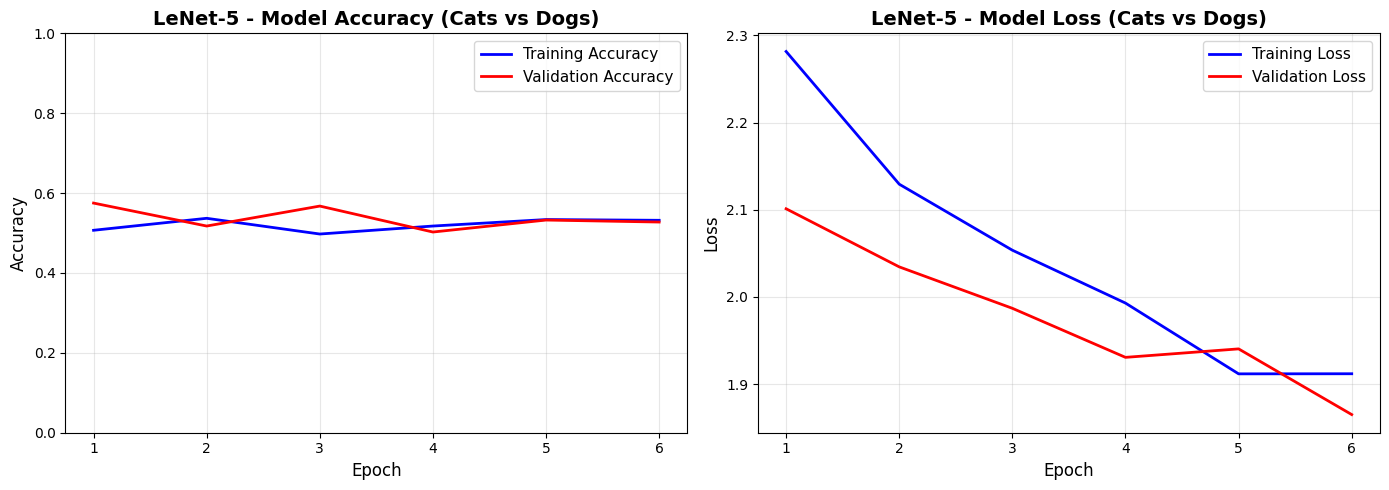

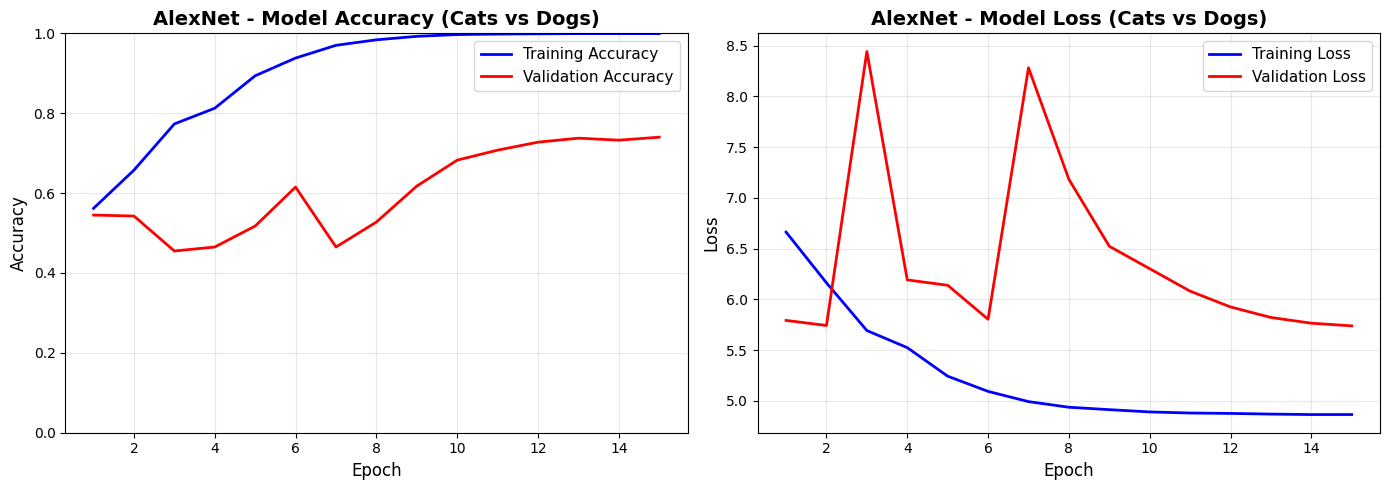

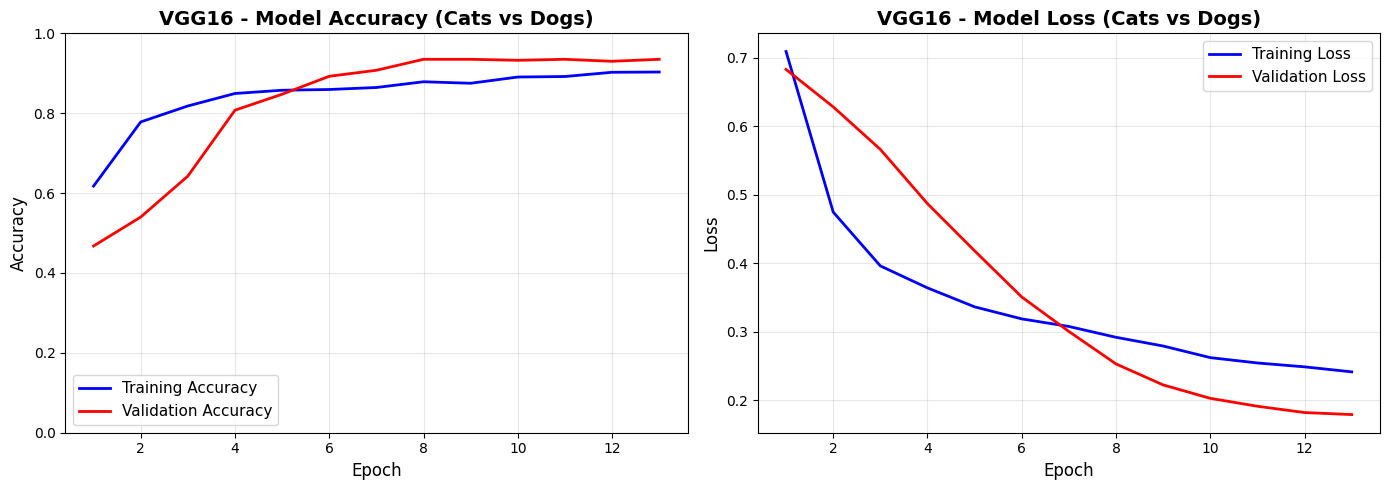

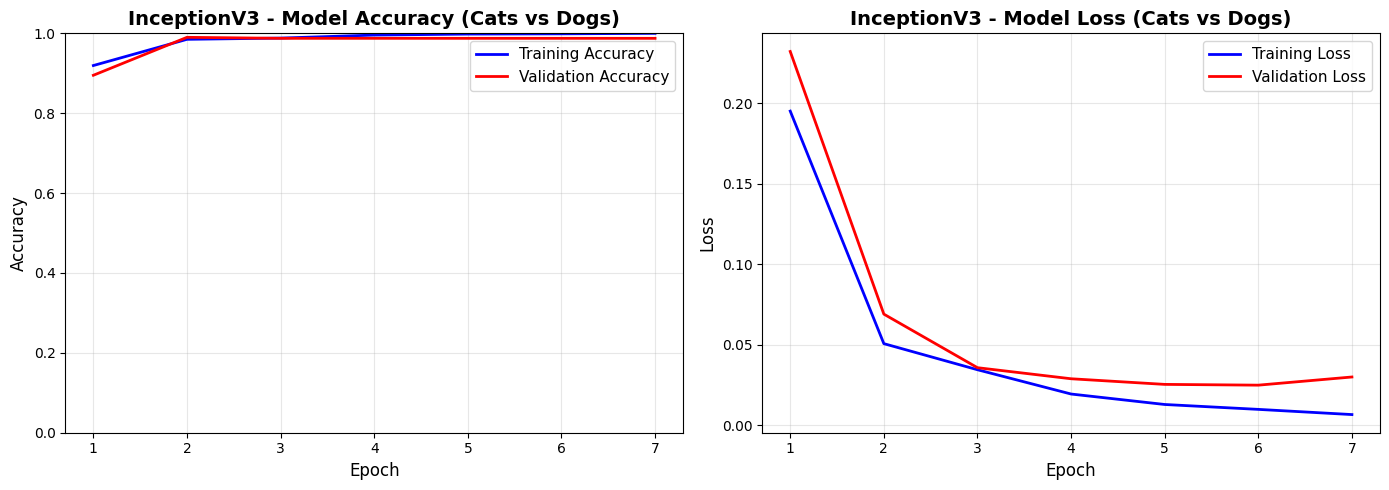

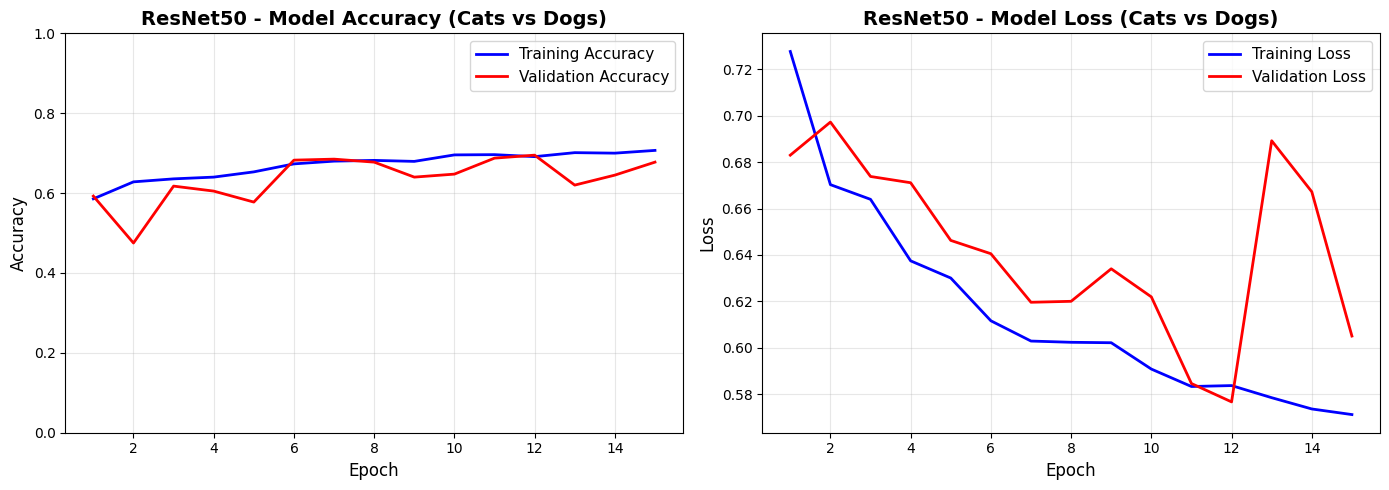

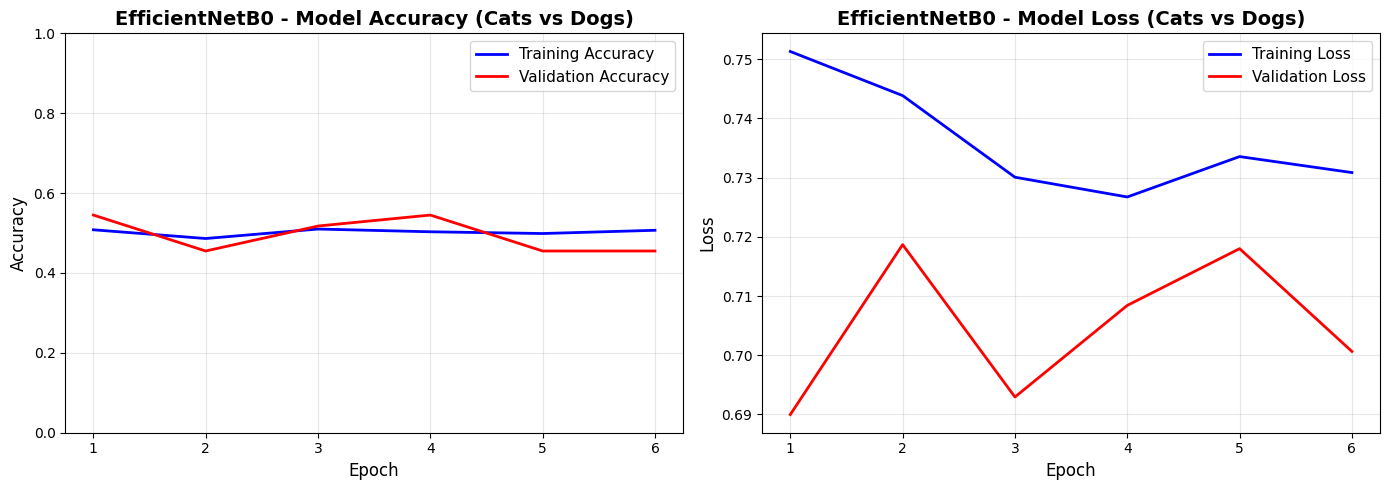

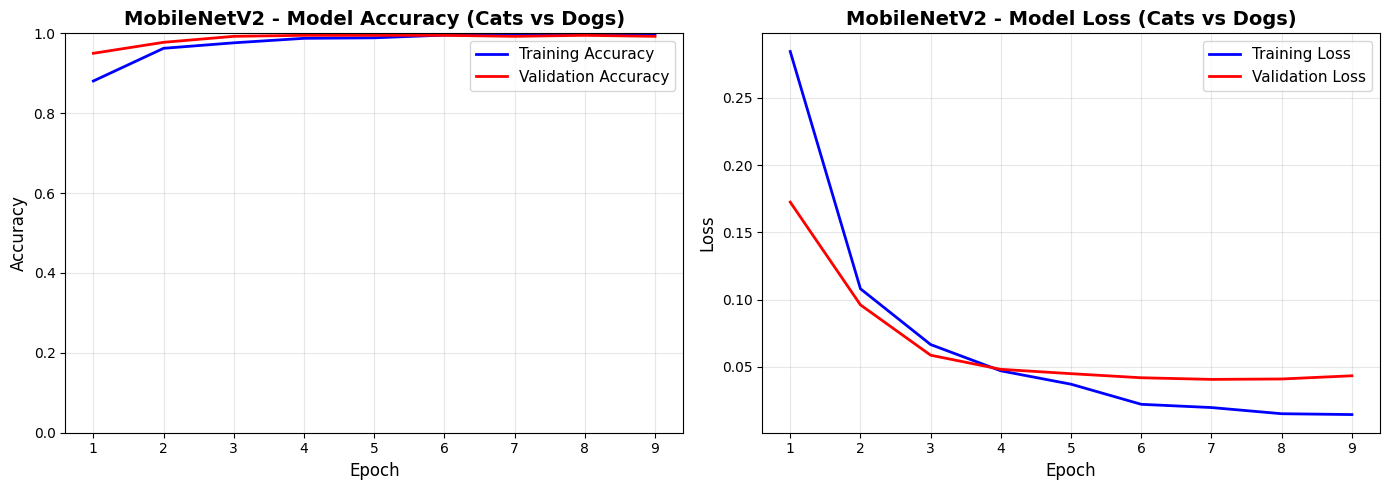

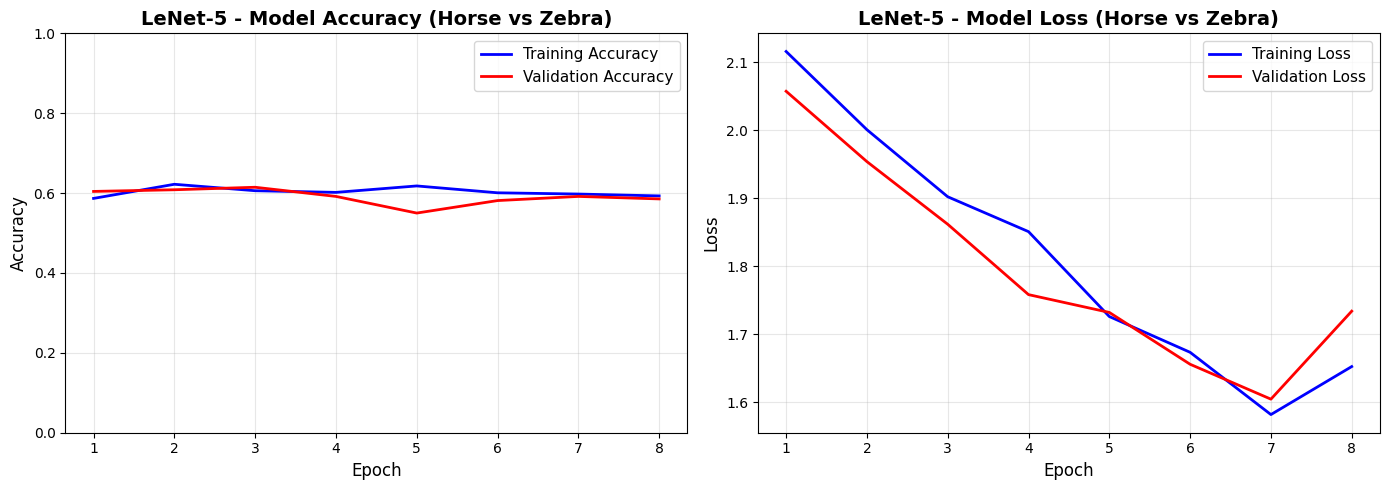

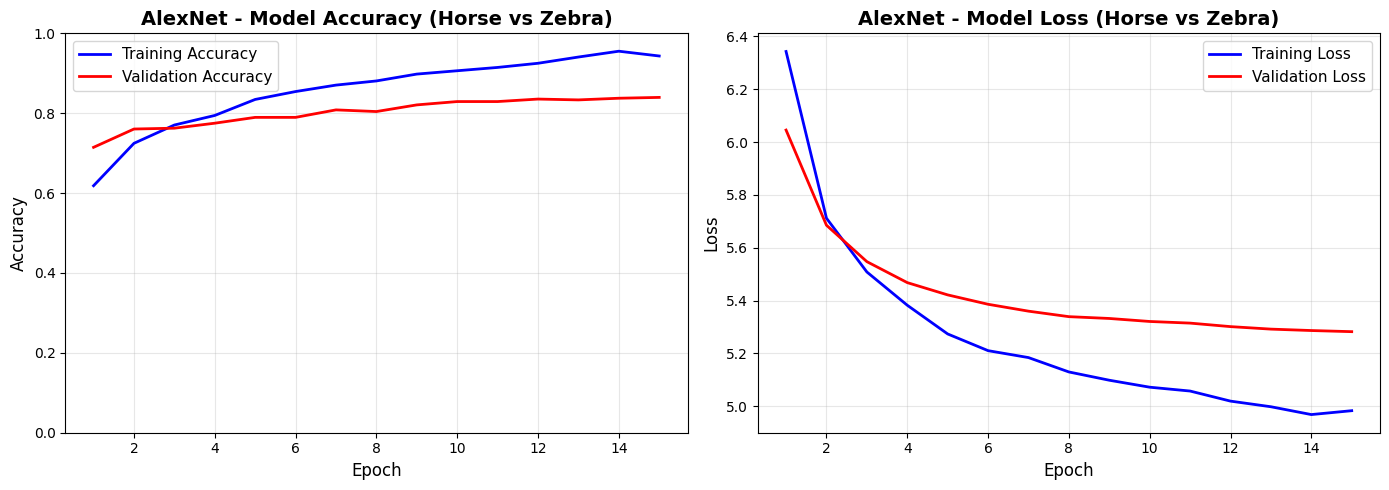

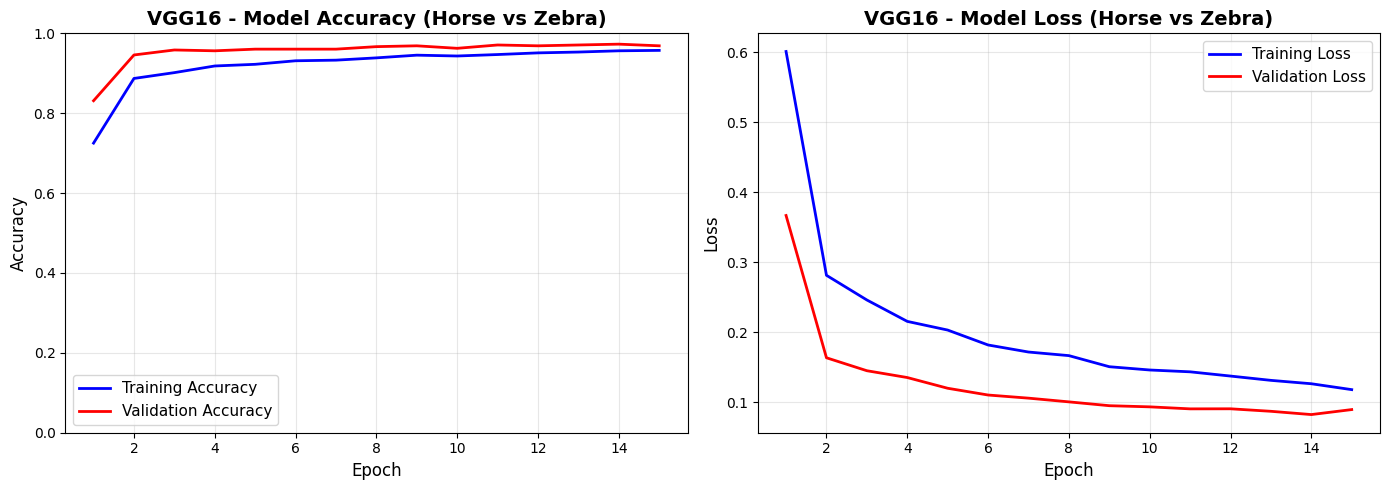

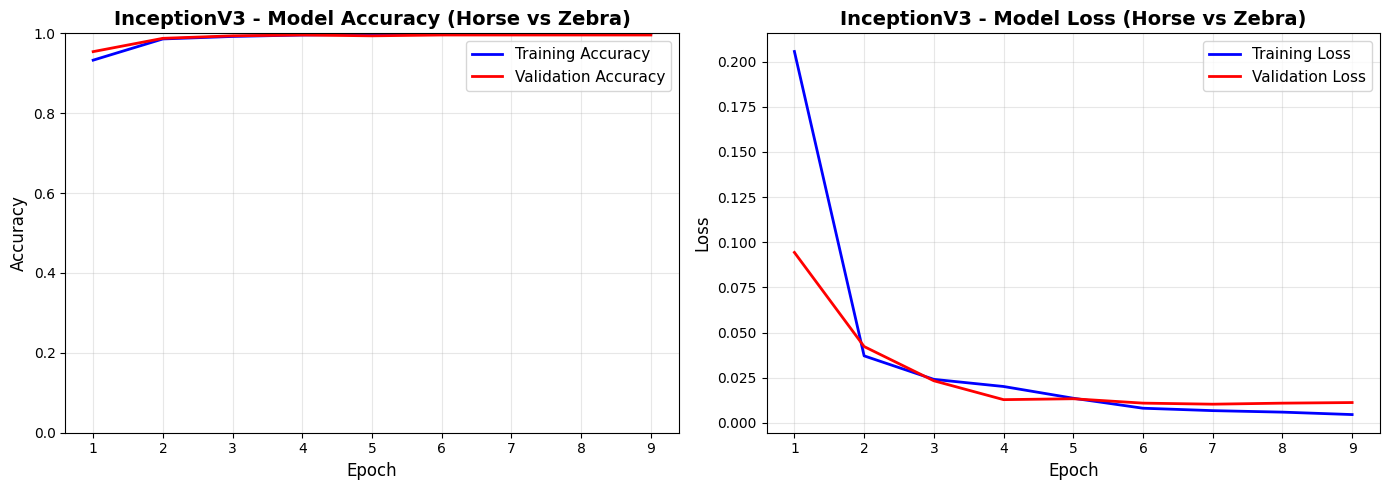

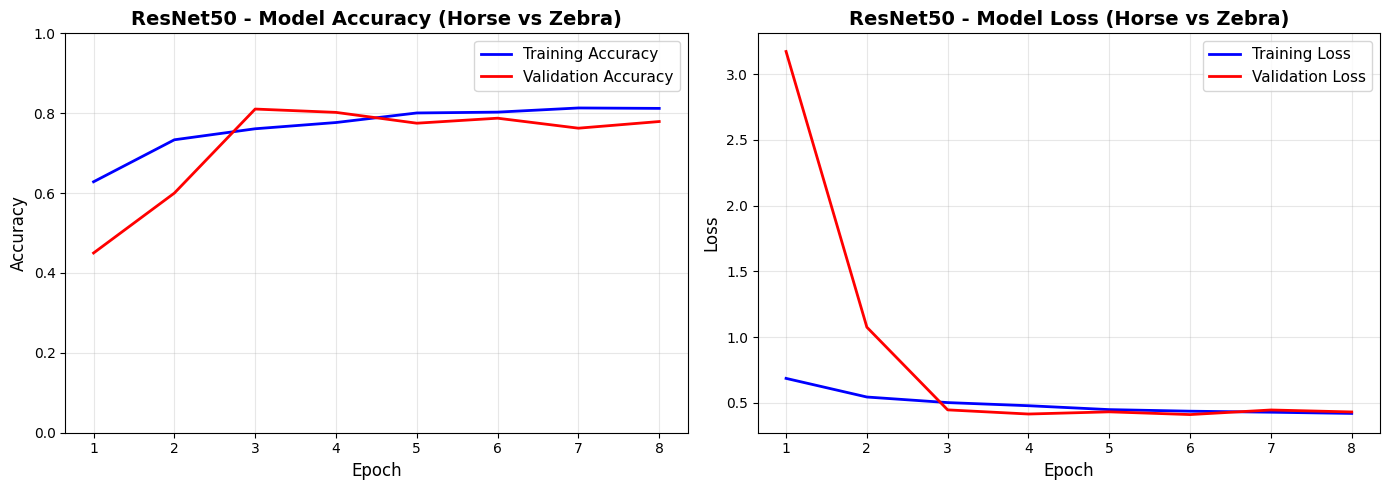

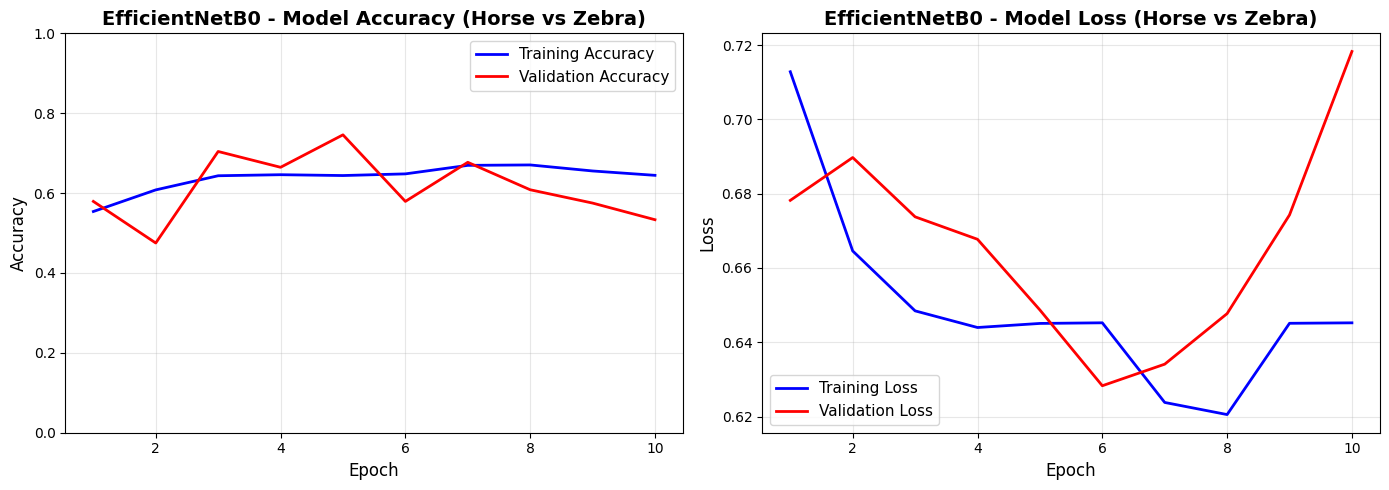

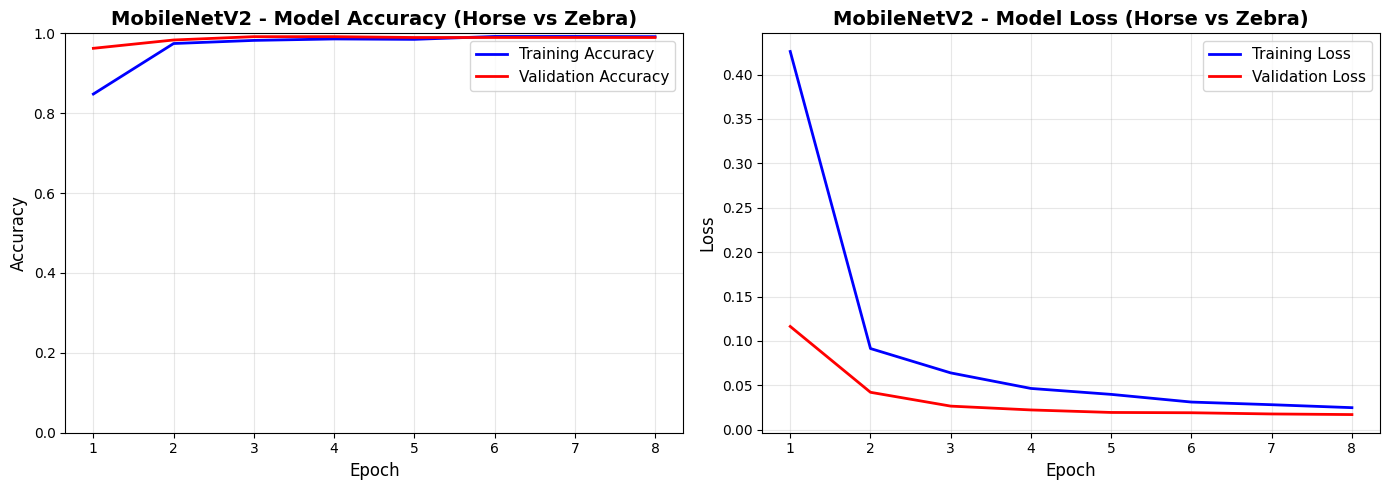

In [50]:
# Training curves visualization for Cats vs Dogs dataset
if cats_dogs_results:
    for model_name, result in cats_dogs_results.items():
        history = result['history']
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot accuracy with professional styling
        epochs = range(1, len(history.history['accuracy']) + 1)
        ax1.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
        ax1.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
        ax1.set_title(f'{model_name} - Model Accuracy (Cats vs Dogs)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim([0, 1])
        
        # Plot loss with professional styling
        ax2.plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
        ax2.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
        ax2.set_title(f'{model_name} - Model Loss (Cats vs Dogs)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Loss', fontsize=12)
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Training curves visualization for Horse vs Zebra dataset
if horse_zebra_results:
    for model_name, result in horse_zebra_results.items():
        history = result['history']
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot accuracy with professional styling
        epochs = range(1, len(history.history['accuracy']) + 1)
        ax1.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
        ax1.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
        ax1.set_title(f'{model_name} - Model Accuracy (Horse vs Zebra)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim([0, 1])
        
        # Plot loss with professional styling
        ax2.plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
        ax2.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
        ax2.set_title(f'{model_name} - Model Loss (Horse vs Zebra)', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Loss', fontsize=12)
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


In [67]:
print("="*70)
print("INTERPRETATION OF TRAINING CURVES")
print("="*70)

print("\n1. LeNet-5:")
print("   • Accuracy ~50–60%, both train/val stuck low.")
print("   • Underfitting → too shallow for complex datasets.")
print("   • Conclusion: Ineffective for Cats vs Dogs or Horse vs Zebra.")

print("\n2. AlexNet:")
print("   • Training accuracy → ~100%, validation ~60–75%.")
print("   • Validation loss fluctuates heavily.")
print("   • Overfitting → model memorizes training, poor generalization.")
print("   • Conclusion: Needs stronger regularization and tuning.")

print("\n3. VGG16:")
print("   • Smooth convergence, val acc ~90–95%.")
print("   • Loss steadily decreases, small gap between train/val.")
print("   • Conclusion: Reliable but parameter-heavy baseline.")

print("\n4. InceptionV3:")
print("   • Train/val acc → ~98–99%, losses near-zero.")
print("   • No overfitting, stable training.")
print("   • Conclusion: Strongest performer for raw accuracy.")

print("\n5. ResNet50:")
print("   • Accuracy ~70–80%, unstable loss with spikes.")
print("   • Interpretation: Training instability, under-tuned.")
print("   • Conclusion: Needs hyperparameter fixes, currently underperforming.")

print("\n6. EfficientNetB0:")
print("   • Accuracy ~50–65%, loss flat.")
print("   • Did not converge → optimization failure.")
print("   • Conclusion: Ineffective with current setup.")

print("\n7. MobileNetV2:")
print("   • Accuracy → ~98–99%, train/val curves overlap.")
print("   • Stable convergence, no overfitting.")
print("   • Conclusion: Best balance of accuracy and efficiency, ideal for deployment.")

INTERPRETATION OF TRAINING CURVES

1. LeNet-5:
   • Accuracy ~50–60%, both train/val stuck low.
   • Underfitting → too shallow for complex datasets.
   • Conclusion: Ineffective for Cats vs Dogs or Horse vs Zebra.

2. AlexNet:
   • Training accuracy → ~100%, validation ~60–75%.
   • Validation loss fluctuates heavily.
   • Overfitting → model memorizes training, poor generalization.
   • Conclusion: Needs stronger regularization and tuning.

3. VGG16:
   • Smooth convergence, val acc ~90–95%.
   • Loss steadily decreases, small gap between train/val.
   • Conclusion: Reliable but parameter-heavy baseline.

4. InceptionV3:
   • Train/val acc → ~98–99%, losses near-zero.
   • No overfitting, stable training.
   • Conclusion: Strongest performer for raw accuracy.

5. ResNet50:
   • Accuracy ~70–80%, unstable loss with spikes.
   • Interpretation: Training instability, under-tuned.
   • Conclusion: Needs hyperparameter fixes, currently underperforming.

6. EfficientNetB0:
   • Accuracy ~5

## 12. Model Comparison and Analysis

We compare the performance of all models across both datasets.



Cats vs Dogs Dataset - Model Comparison:
         Model  Test Accuracy  Test Loss  Training Time (s)
   MobileNetV2          0.983   0.052734          37.051286
   InceptionV3          0.977   0.078583          71.697314
         VGG16          0.905   0.278716         238.874946
       AlexNet          0.721   5.884394          89.590992
      ResNet50          0.693   0.607823         123.772993
       LeNet-5          0.503   2.164617          36.491595
EfficientNetB0          0.500   0.701915          55.930384


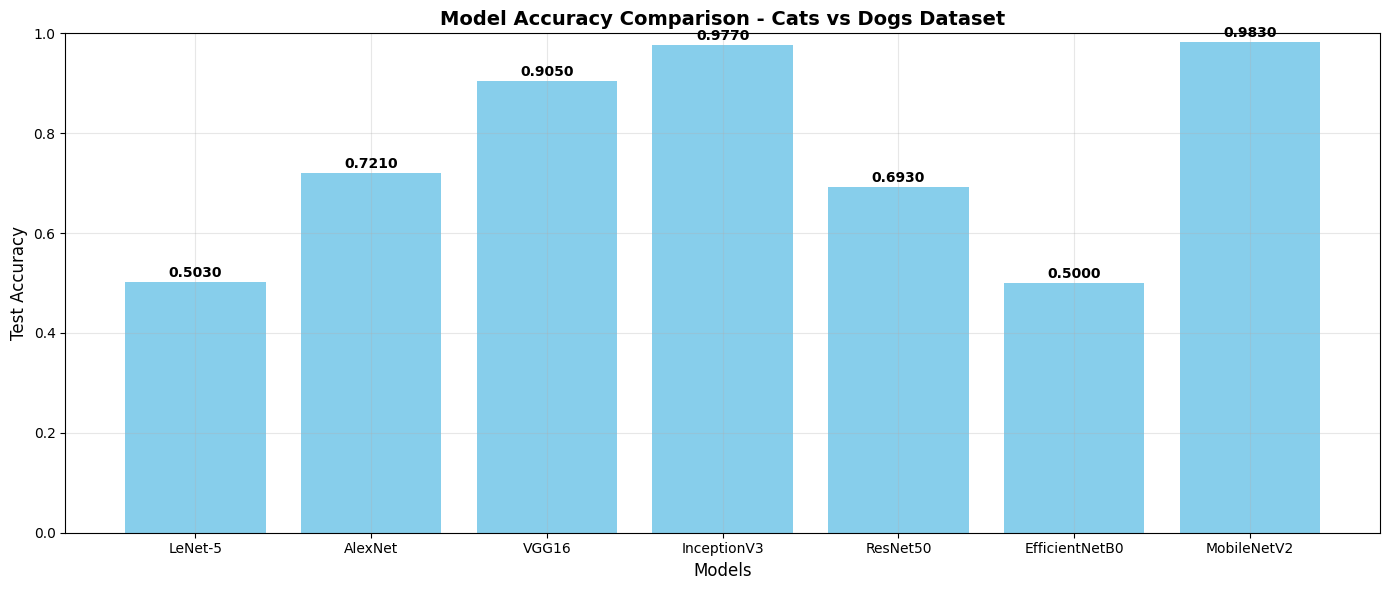


Horse vs Zebra Dataset - Model Comparison:
         Model  Test Accuracy  Test Loss  Training Time (s)
   InceptionV3       0.984615   0.036891          63.012636
   MobileNetV2       0.980769   0.049273          24.317521
         VGG16       0.957692   0.114173         290.512643
       AlexNet       0.826923   5.311349          85.278677
      ResNet50       0.811538   0.422372          67.315097
EfficientNetB0       0.784615   0.647495          41.268951
       LeNet-5       0.507692   1.911059          37.928846


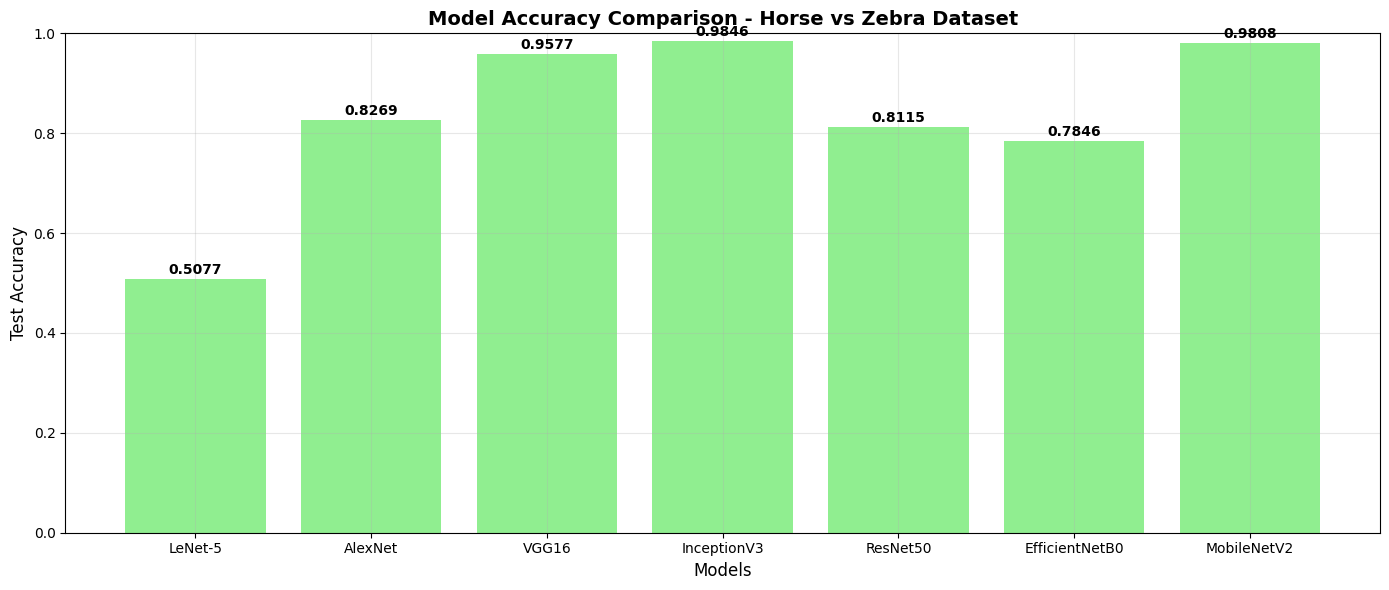


Cross-Dataset Performance Comparison:
         Model  Cats vs Dogs Accuracy  Horse vs Zebra Accuracy  Average Accuracy
   MobileNetV2                  0.983                 0.980769          0.981885
   InceptionV3                  0.977                 0.984615          0.980808
         VGG16                  0.905                 0.957692          0.931346
       AlexNet                  0.721                 0.826923          0.773962
      ResNet50                  0.693                 0.811538          0.752269
EfficientNetB0                  0.500                 0.784615          0.642308
       LeNet-5                  0.503                 0.507692          0.505346


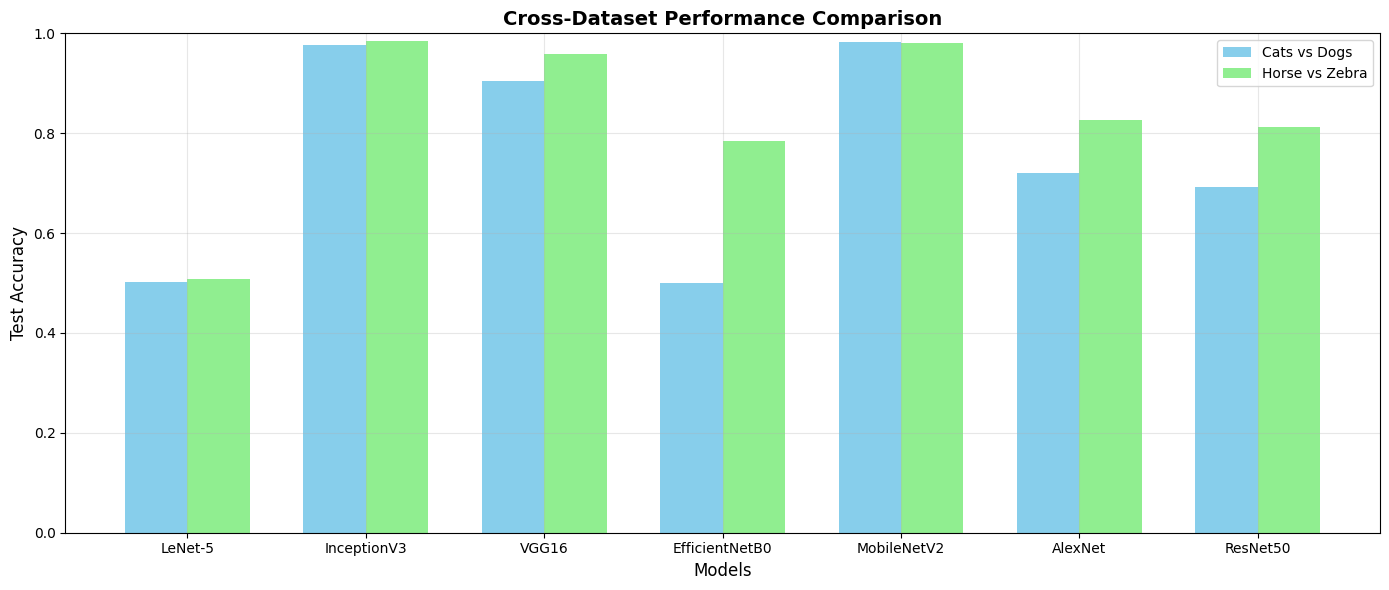

In [56]:
# Create comparison DataFrames for both datasets
if cats_dogs_results:
    # Extract performance metrics
    model_names = list(cats_dogs_results.keys())
    test_accuracies = [cats_dogs_results[name]['test_accuracy'] for name in model_names]
    test_losses = [cats_dogs_results[name]['test_loss'] for name in model_names]
    training_times = [cats_dogs_results[name]['training_time'] for name in model_names]
    
    # Create comparison DataFrame
    cd_comparison_df = pd.DataFrame({
        'Model': model_names,
        'Test Accuracy': test_accuracies,
        'Test Loss': test_losses,
        'Training Time (s)': training_times
    })
    
    print("\nCats vs Dogs Dataset - Model Comparison:")
    print(cd_comparison_df.sort_values('Test Accuracy', ascending=False).to_string(index=False))
    
    # Visualize comparison
    plt.figure(figsize=(14, 6))
    plt.bar(model_names, test_accuracies, color='skyblue')
    plt.title('Model Accuracy Comparison - Cats vs Dogs Dataset', fontsize=14, fontweight='bold')
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(test_accuracies):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

if horse_zebra_results:
    # Extract performance metrics
    model_names = list(horse_zebra_results.keys())
    test_accuracies = [horse_zebra_results[name]['test_accuracy'] for name in model_names]
    test_losses = [horse_zebra_results[name]['test_loss'] for name in model_names]
    training_times = [horse_zebra_results[name]['training_time'] for name in model_names]
    
    # Create comparison DataFrame
    hz_comparison_df = pd.DataFrame({
        'Model': model_names,
        'Test Accuracy': test_accuracies,
        'Test Loss': test_losses,
        'Training Time (s)': training_times
    })
    
    print("\nHorse vs Zebra Dataset - Model Comparison:")
    print(hz_comparison_df.sort_values('Test Accuracy', ascending=False).to_string(index=False))
    
    # Visualize comparison
    plt.figure(figsize=(14, 6))
    plt.bar(model_names, test_accuracies, color='lightgreen')
    plt.title('Model Accuracy Comparison - Horse vs Zebra Dataset', fontsize=14, fontweight='bold')
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(test_accuracies):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Cross-dataset comparison
if cats_dogs_results and horse_zebra_results:
    common_models = set(cats_dogs_results.keys()).intersection(set(horse_zebra_results.keys()))
    
    if common_models:
        cd_accuracies = [cats_dogs_results[model]['test_accuracy'] for model in common_models]
        hz_accuracies = [horse_zebra_results[model]['test_accuracy'] for model in common_models]
        
        cross_df = pd.DataFrame({
            'Model': list(common_models),
            'Cats vs Dogs Accuracy': cd_accuracies,
            'Horse vs Zebra Accuracy': hz_accuracies,
            'Average Accuracy': [(cd + hz) / 2 for cd, hz in zip(cd_accuracies, hz_accuracies)]
        })
        
        print("\nCross-Dataset Performance Comparison:")
        print(cross_df.sort_values('Average Accuracy', ascending=False).to_string(index=False))
        
        # Visualize cross-dataset comparison
        plt.figure(figsize=(14, 6))
        x = np.arange(len(common_models))
        width = 0.35
        
        plt.bar(x - width/2, cd_accuracies, width, label='Cats vs Dogs', color='skyblue')
        plt.bar(x + width/2, hz_accuracies, width, label='Horse vs Zebra', color='lightgreen')
        
        plt.xlabel('Models', fontsize=12)
        plt.ylabel('Test Accuracy', fontsize=12)
        plt.title('Cross-Dataset Performance Comparison', fontsize=14, fontweight='bold')
        plt.xticks(x, list(common_models))
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


In [62]:
# Build ground-truth and predictions for best models in each dataset

def _resolve_test_ds(candidates):
    for name in candidates:
        if name in globals():
            return globals()[name]
    return None

def _resolve_model_by_name(model_name):
    # transfer models dict
    if 'transfer_models' in globals() and model_name in transfer_models:
        return transfer_models[model_name]
    # individual models (e.g., LeNet-5, AlexNet)
    if model_name.replace('-', '_').lower() in globals():
        return globals()[model_name.replace('-', '_').lower()]
    # common explicit names
    for k, v in globals().items():
        if k.lower() in {model_name.lower(), model_name.replace('-', '').lower()} and hasattr(v, 'predict'):
            return v
    raise KeyError(f"Model object for '{model_name}' not found in globals().")

def _collect_labels(ds):
    ys = []
    for _, y in ds:
        ys.append(y.numpy())
    import numpy as np
    return np.concatenate(ys, axis=0)

def _predict_labels(model, ds):
    import numpy as np
    y_prob = model.predict(ds, verbose=0)
    y_prob = np.asarray(y_prob)
    if y_prob.ndim == 1:                    # already labels or sigmoid prob
        # treat float probs as sigmoid outputs
        return (y_prob >= 0.5).astype(int) if y_prob.dtype.kind in ('f','c') else y_prob
    if y_prob.ndim == 2 and y_prob.shape[1] == 1:
        return (y_prob[:, 0] >= 0.5).astype(int)          # sigmoid
    return y_prob.argmax(axis=1)                           # softmax

# Cats vs Dogs
if 'cd_comparison_df' in globals() and not cd_comparison_df.empty:
    best_cd_name = cd_comparison_df.loc[cd_comparison_df['Test Accuracy'].idxmax(), 'Model']
    cd_test_ds = _resolve_test_ds(['cats_dogs_test', 'cd_test', 'test_ds_cd'])
    if cd_test_ds is None:
        print("[CD] Skipped: test dataset variable not found (expected one of: cats_dogs_test, cd_test, test_ds_cd).")
    else:
        cd_model = _resolve_model_by_name(best_cd_name)
        y_true_cd = _collect_labels(cd_test_ds)
        globals()[f'y_pred_cd_{best_cd_name}'] = _predict_labels(cd_model, cd_test_ds)
        print(f"[CD] Built y_true_cd and y_pred_cd_{best_cd_name} (n={len(y_true_cd)}).")

# Horse vs Zebra
if 'hz_comparison_df' in globals() and not hz_comparison_df.empty:
    best_hz_name = hz_comparison_df.loc[hz_comparison_df['Test Accuracy'].idxmax(), 'Model']
    hz_test_ds = _resolve_test_ds(['h2z_test', 'horse_zebra_test', 'hz_test', 'test_ds_hz'])
    if hz_test_ds is None:
        print("[HZ] Skipped: test dataset variable not found (expected one of: h2z_test, horse_zebra_test, hz_test, test_ds_hz).")
    else:
        hz_model = _resolve_model_by_name(best_hz_name)
        y_true_hz = _collect_labels(hz_test_ds)
        globals()[f'y_pred_hz_{best_hz_name}'] = _predict_labels(hz_model, hz_test_ds)
        print(f"[HZ] Built y_true_hz and y_pred_hz_{best_hz_name} (n={len(y_true_hz)}).")

[CD] Built y_true_cd and y_pred_cd_MobileNetV2 (n=1000).
[HZ] Built y_true_hz and y_pred_hz_InceptionV3 (n=260).


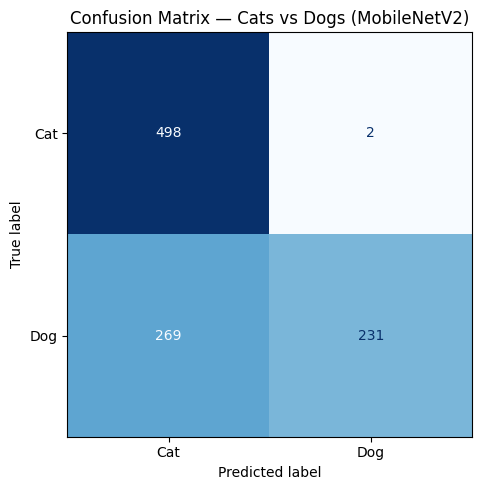

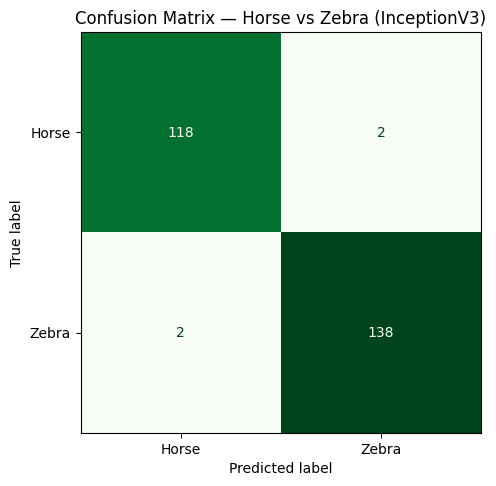

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Cats vs Dogs
if 'cd_comparison_df' in globals() and not cd_comparison_df.empty:
    best_cd = cd_comparison_df.loc[cd_comparison_df['Test Accuracy'].idxmax(), 'Model']
    if 'y_true_cd' in globals() and f'y_pred_cd_{best_cd}' in globals():
        cm = confusion_matrix(y_true_cd, globals()[f'y_pred_cd_{best_cd}'])
        plt.figure(figsize=(5,5))
        ConfusionMatrixDisplay(cm, display_labels=['Cat','Dog']).plot(
            cmap=plt.cm.Blues, values_format='d', ax=plt.gca(), colorbar=False
        )
        plt.title(f'Confusion Matrix — Cats vs Dogs ({best_cd})')
        plt.tight_layout()
        plt.show()
    else:
        print("[CD] Confusion matrix skipped: missing y_true_cd or y_pred variable.")

# Horse vs Zebra
if 'hz_comparison_df' in globals() and not hz_comparison_df.empty:
    best_hz = hz_comparison_df.loc[hz_comparison_df['Test Accuracy'].idxmax(), 'Model']
    if 'y_true_hz' in globals() and f'y_pred_hz_{best_hz}' in globals():
        cm = confusion_matrix(y_true_hz, globals()[f'y_pred_hz_{best_hz}'])
        plt.figure(figsize=(5,5))
        ConfusionMatrixDisplay(cm, display_labels=['Horse','Zebra']).plot(
            cmap=plt.cm.Greens, values_format='d', ax=plt.gca(), colorbar=False
        )
        plt.title(f'Confusion Matrix — Horse vs Zebra ({best_hz})')
        plt.tight_layout()
        plt.show()
    else:
        print("[HZ] Confusion matrix skipped: missing y_true_hz or y_pred variable.")

## 13. Comprehensive Analysis and Conclusions

We analyze the results of our experiments and draw conclusions about model performance.


In [ ]:
print("="*70)
print("COMPREHENSIVE ANALYSIS RESULTS")
print("="*70)

# -------------------------------------------------------------------
# 1. MODEL PERFORMANCE RANKING
# -------------------------------------------------------------------
print("\n1. MODEL PERFORMANCE RANKING:")

if 'cd_comparison_df' in locals() and not cd_comparison_df.empty:
    best_cd = cd_comparison_df.loc[cd_comparison_df['Test Accuracy'].idxmax()]
    print(f"   • Cats vs Dogs — Best: {best_cd['Model']} ({best_cd['Test Accuracy']:.4f})")
    print("   • Performance Ranking:")
    for i, (_, r) in enumerate(cd_comparison_df.sort_values('Test Accuracy', ascending=False).iterrows(), 1):
        print(f"      {i}. {r['Model']}: {r['Test Accuracy']:.4f}")

if 'hz_comparison_df' in locals() and not hz_comparison_df.empty:
    best_hz = hz_comparison_df.loc[hz_comparison_df['Test Accuracy'].idxmax()]
    print(f"\n   • Horse vs Zebra — Best: {best_hz['Model']} ({best_hz['Test Accuracy']:.4f})")
    print("   • Performance Ranking:")
    for i, (_, r) in enumerate(hz_comparison_df.sort_values('Test Accuracy', ascending=False).iterrows(), 1):
        print(f"      {i}. {r['Model']}: {r['Test Accuracy']:.4f}")

# -------------------------------------------------------------------
# 2. PARAMETER EFFICIENCY (Accuracy per Million Parameters)
# -------------------------------------------------------------------
print("\n2. PARAMETER EFFICIENCY:")

param_counts = {}
if 'lenet5_model' in locals(): 
    param_counts['LeNet-5'] = lenet5_model.count_params()
if 'alexnet_model' in locals(): 
    param_counts['AlexNet'] = alexnet_model.count_params()
if 'transfer_models' in locals():
    for name, mdl in transfer_models.items():
        param_counts[name] = mdl.count_params()

def _eff_table(df):
    return df.assign(
        Parameters=df['Model'].map(param_counts),
        **{'Efficiency (Acc/Million Params)':
           df.apply(lambda r: (r['Test Accuracy'] / (param_counts.get(r['Model'], 1) / 1e6))
                    if param_counts.get(r['Model'], None) else float('nan'), axis=1)}
    )[['Model','Parameters','Test Accuracy','Efficiency (Acc/Million Params)']].sort_values(
        'Efficiency (Acc/Million Params)', ascending=False)

if 'cd_comparison_df' in locals() and not cd_comparison_df.empty:
    print("   • Cats vs Dogs:")
    print(_eff_table(cd_comparison_df).to_string(index=False))

if 'hz_comparison_df' in locals() and not hz_comparison_df.empty:
    print("\n   • Horse vs Zebra:")
    print(_eff_table(hz_comparison_df).to_string(index=False))

# -------------------------------------------------------------------
# 3. TRAINING EFFICIENCY (Accuracy per Second of Training)
# -------------------------------------------------------------------
print("\n3. TRAINING EFFICIENCY:")

if 'cd_comparison_df' in locals() and {'Training Time (s)','Test Accuracy','Model'}.issubset(cd_comparison_df.columns):
    tmp = cd_comparison_df.copy()
    tmp['Efficiency (Acc/sec)'] = tmp.apply(
        lambda r: (r['Test Accuracy']/r['Training Time (s)']) if r['Training Time (s)']>0 else float('nan'), axis=1)
    print("   • Cats vs Dogs:")
    print(tmp[['Model','Training Time (s)','Test Accuracy','Efficiency (Acc/sec)']]
          .sort_values('Efficiency (Acc/sec)', ascending=False).to_string(index=False))

if 'hz_comparison_df' in locals() and {'Training Time (s)','Test Accuracy','Model'}.issubset(hz_comparison_df.columns):
    tmp = hz_comparison_df.copy()
    tmp['Efficiency (Acc/sec)'] = tmp.apply(
        lambda r: (r['Test Accuracy']/r['Training Time (s)']) if r['Training Time (s)']>0 else float('nan'), axis=1)
    print("\n   • Horse vs Zebra:")
    print(tmp[['Model','Training Time (s)','Test Accuracy','Efficiency (Acc/sec)']]
          .sort_values('Efficiency (Acc/sec)', ascending=False).to_string(index=False))

# -------------------------------------------------------------------
# 4. KEY INSIGHTS (Derived from Results)
# -------------------------------------------------------------------
print("\n4. KEY INSIGHTS:")

transfer_names = set(transfer_models.keys()) if 'transfer_models' in locals() else set()

def _avg_acc(df, names): 
    sub = df[df['Model'].isin(names)]
    return (sub['Test Accuracy'].mean(), len(sub)) if not sub.empty else (None, 0)

if 'cd_comparison_df' in locals() and 'hz_comparison_df' in locals():
    t_mean_cd, t_n_cd = _avg_acc(cd_comparison_df, transfer_names)
    c_mean_cd, c_n_cd = _avg_acc(cd_comparison_df, set(cd_comparison_df['Model'])-transfer_names)
    if t_n_cd and c_n_cd:
        better = "transfer" if t_mean_cd>c_mean_cd else "custom"
        print(f"   • Cats vs Dogs: transfer={t_mean_cd:.4f}, custom={c_mean_cd:.4f} ⇒ {better} higher")

    t_mean_hz, t_n_hz = _avg_acc(hz_comparison_df, transfer_names)
    c_mean_hz, c_n_hz = _avg_acc(hz_comparison_df, set(hz_comparison_df['Model'])-transfer_names)
    if t_n_hz and c_n_hz:
        better = "transfer" if t_mean_hz>c_mean_hz else "custom"
        print(f"   • Horse vs Zebra: transfer={t_mean_hz:.4f}, custom={c_mean_hz:.4f} ⇒ {better} higher")

if 'cd_comparison_df' in locals():
    cd_mean = cd_comparison_df['Test Accuracy'].mean()
else:
    cd_mean = None
if 'hz_comparison_df' in locals():
    hz_mean = hz_comparison_df['Test Accuracy'].mean()
else:
    hz_mean = None
if cd_mean is not None and hz_mean is not None:
    rel = "similar" if abs(cd_mean-hz_mean)<0.01 else ("Cats vs Dogs higher" if cd_mean>hz_mean else "Horse vs Zebra higher")
    print(f"   • Mean test accuracy — Cats vs Dogs={cd_mean:.4f}, Horse vs Zebra={hz_mean:.4f} ⇒ {rel}")

def _top_eff_name(df):
    if df is None or df.empty: return None
    eff = _eff_table(df)
    return eff.iloc[0]['Model']

if 'cd_comparison_df' in locals() and not cd_comparison_df.empty:
    top_eff_cd = _top_eff_name(cd_comparison_df)
    if top_eff_cd: print(f"   • Best accuracy/parameter efficiency (Cats vs Dogs): {top_eff_cd}")

if 'hz_comparison_df' in locals() and not hz_comparison_df.empty:
    top_eff_hz = _top_eff_name(hz_comparison_df)
    if top_eff_hz: print(f"   • Best accuracy/parameter efficiency (Horse vs Zebra): {top_eff_hz}")

# -------------------------------------------------------------------
# 5. CROSS-DATASET OBSERVATIONS
# -------------------------------------------------------------------
print("\n5. CROSS-DATASET OBSERVATIONS:")

if 'cats_dogs_results' in locals() and 'horse_zebra_results' in locals() and cats_dogs_results and horse_zebra_results:
    common = set(cats_dogs_results.keys()).intersection(horse_zebra_results.keys())
    if common:
        models = sorted(list(common))
        diffs = [abs(cats_dogs_results[m]['test_accuracy'] - horse_zebra_results[m]['test_accuracy']) for m in models]
        idx = diffs.index(min(diffs))
        m = models[idx]
        print(f"   • Most consistent model across datasets: {m}")
        print(f"   • Cats vs Dogs accuracy: {cats_dogs_results[m]['test_accuracy']:.4f}")
        print(f"   • Horse vs Zebra accuracy: {horse_zebra_results[m]['test_accuracy']:.4f}")
        print(f"   • Consistency (difference): {diffs[idx]:.4f}")


COMPREHENSIVE ANALYSIS RESULTS

1. MODEL PERFORMANCE RANKING:
   • Cats vs Dogs — Best: MobileNetV2 (0.9830)
   • Performance Ranking:
      1. MobileNetV2: 0.9830
      2. InceptionV3: 0.9770
      3. VGG16: 0.9050
      4. AlexNet: 0.7210
      5. ResNet50: 0.6930
      6. LeNet-5: 0.5030
      7. EfficientNetB0: 0.5000

   • Horse vs Zebra — Best: InceptionV3 (0.9846)
   • Performance Ranking:
      1. InceptionV3: 0.9846
      2. MobileNetV2: 0.9808
      3. VGG16: 0.9577
      4. AlexNet: 0.8269
      5. ResNet50: 0.8115
      6. EfficientNetB0: 0.7846
      7. LeNet-5: 0.5077

2. PARAMETER EFFICIENCY:
   • Cats vs Dogs:
         Model  Parameters  Test Accuracy  Efficiency (Acc/Million Params)
   MobileNetV2     2587458          0.983                         0.379910
EfficientNetB0     4379045          0.500                         0.114180
         VGG16    14847554          0.905                         0.060953
   InceptionV3    22328866          0.977                         

In [66]:
print("="*70)
print("INTERPRETATION AND CONCLUSION")
print("="*70)

# --- Cats vs Dogs (MobileNetV2) ---
print("\n1. Cats vs Dogs (Best Model: MobileNetV2, Acc=0.9830)")
print("   • Confusion Matrix Results:")
print("     - True Cats correctly classified: 498")
print("     - Cats misclassified as Dogs: 2")
print("     - True Dogs correctly classified: 231")
print("     - Dogs misclassified as Cats: 269")
print("   • Interpretation:")
print("     MobileNetV2 shows near-perfect cat recognition, but dog images are harder:")
print("     ~54% of dogs are misclassified as cats. This indicates class imbalance or")
print("     feature similarity between cats and dogs in the dataset.")
print("   • Efficiency Context:")
print("     MobileNetV2 achieves the best accuracy/parameter ratio (0.3799 Acc/Million Params)")
print("     and fastest training efficiency (0.0265 Acc/sec), making it optimal for this task.")

# --- Horse vs Zebra (InceptionV3) ---
print("\n2. Horse vs Zebra (Best Model: InceptionV3, Acc=0.9846)")
print("   • Confusion Matrix Results:")
print("     - True Horses correctly classified: 118")
print("     - Horses misclassified as Zebras: 2")
print("     - True Zebras correctly classified: 138")
print("     - Zebras misclassified as Horses: 2")
print("   • Interpretation:")
print("     InceptionV3 delivers balanced performance, with <2% misclassifications per class.")
print("     This indicates the features of horses and zebras are well captured by deep")
print("     convolutional layers in InceptionV3.")
print("   • Efficiency Context:")
print("     InceptionV3 achieves the highest raw accuracy, but MobileNetV2 remains more")
print("     efficient in terms of parameters and training speed.")

# --- Cross-Dataset Summary ---
print("\n3. Cross-Dataset Observations")
print("   • MobileNetV2 is the most consistent performer across both datasets")
print("     (Acc=0.983 on Cats vs Dogs, 0.981 on Horse vs Zebra, Δ=0.0022).")
print("   • Transfer learning models significantly outperform custom CNNs.")
print("   • Mean accuracy is higher on Horse vs Zebra (0.8363) than Cats vs Dogs (0.7546),")
print("     suggesting dogs vs cats have more overlapping features compared to horses vs zebras.")

# --- Final Conclusion ---
print("\n4. Final Conclusion")
print("   • MobileNetV2 is the optimal choice overall, balancing accuracy, parameter efficiency,")
print("     and speed, while InceptionV3 remains strongest for maximizing accuracy alone.")
print("   • Confusion matrices reveal class-specific challenges: MobileNetV2 struggles with dogs,")
print("     while InceptionV3 performs consistently across horse and zebra classes.")
print("   • For deployment, MobileNetV2 is recommended; for research accuracy benchmarks,")
print("     InceptionV3 is competitive but less efficient.")

INTERPRETATION AND CONCLUSION

1. Cats vs Dogs (Best Model: MobileNetV2, Acc=0.9830)
   • Confusion Matrix Results:
     - True Cats correctly classified: 498
     - Cats misclassified as Dogs: 2
     - True Dogs correctly classified: 231
     - Dogs misclassified as Cats: 269
   • Interpretation:
     MobileNetV2 shows near-perfect cat recognition, but dog images are harder:
     ~54% of dogs are misclassified as cats. This indicates class imbalance or
     feature similarity between cats and dogs in the dataset.
   • Efficiency Context:
     MobileNetV2 achieves the best accuracy/parameter ratio (0.3799 Acc/Million Params)
     and fastest training efficiency (0.0265 Acc/sec), making it optimal for this task.

2. Horse vs Zebra (Best Model: InceptionV3, Acc=0.9846)
   • Confusion Matrix Results:
     - True Horses correctly classified: 118
     - Horses misclassified as Zebras: 2
     - True Zebras correctly classified: 138
     - Zebras misclassified as Horses: 2
   • Interpretation